# Source Extraction

Trying to take our single queried image and put it through SEP to get a segmentation map. Note that SEP has a dependence on numpy but is incompatible with numpy versions 2.0 and later. This code was written on a machine installed with numpy 1.26.4

Primarily from the [SEP documentation](https://sep.readthedocs.io/en/stable/tutorial.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits as fits
from astropy.wcs import WCS
import sep

## Getting image

Loading up the image from decam. See query_images.ipynb for details.

/Users/vernica/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


(1990, 3989)

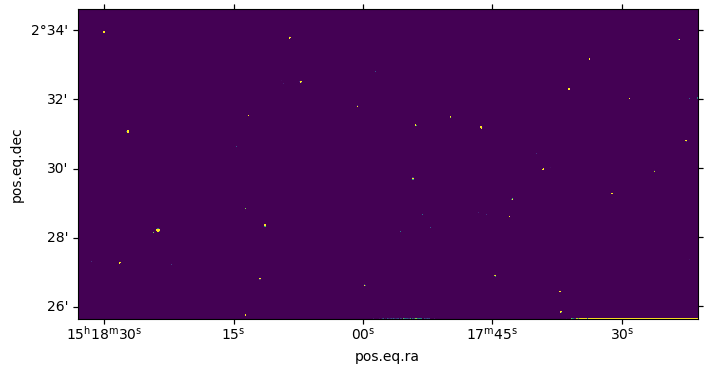

In [2]:
import requests
import pandas as pd

baseurl = "https://astroarchive.noirlab.edu/api"
url = f'{baseurl}/sia/vohdu?FORMAT=METADATA&format=json'
instrument = 'decam'

ra = 229.63841667
dec = 2.08102778   

size = 1.0 
limit = 10
format = 'json'

prod_type = 'image'
image_type = 'resampled'

sia_request = f"{baseurl}/sia/vohdu?" + f"instrument={instrument}" +f"&POS={ra},{dec}" + f"&SIZE={size}" + \
    f"&prod_type={prod_type}" + f"&proc_type={image_type}" + f"&VERB=2" + f"&limit={limit}" + f"&format={format}"

sia_df = pd.DataFrame(requests.get(sia_request).json()[1:])
sia_df.columns
hdu_index = 2
file_id = sia_df['md5sum'][hdu_index]

single_image_url = f'{baseurl}/retrieve/{file_id}/?hdus={hdu_index}'
single_image_url = sia_df['url'][hdu_index]
single_image = fits.open(single_image_url)

wcs = WCS(single_image[1].header)
zimage = single_image[1].data

fig = plt.figure(figsize=(8,16))
ax = plt.subplot(111, projection=wcs)
lon = ax.coords['ra']
lat = ax.coords['dec']
plt.imshow(zimage,vmin=90,vmax=200)
zimage.shape

## Thresholding

We want a magnitude limit of $m_{\text{AB},g}\leq21$, so we need to find the corresponding threshold (related to pixel value). For this we need a zero point. The zero point in this particular image is around 27. We are as yet unsure how to convert magnitude limit to pixel threshold in a meaningful way, so we use an arbitrary value.

In [3]:
## Finding the right zero point to know which threshold to use



## Extraction

We assume that the image is already background subtracted, so we are going straight to extracting sources. Running sep.extract gives two arrays - the first is just the image itself, the second is the segmentation map which is an array of the same shape as the image, where each pixel is assigned an integer value. For our purpose, we only need to extract the integers with a value of 0 (dark regions).

In [4]:
objects = sep.extract(zimage, 200, segmentation_map=True)
seg_map = objects[1]

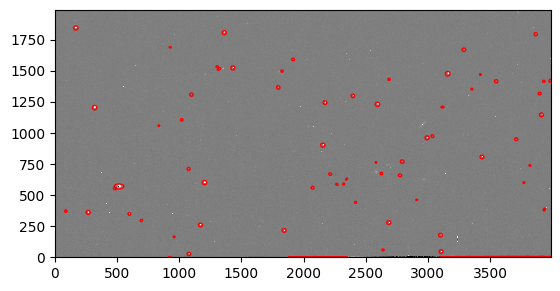

In [5]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(zimage), np.std(zimage)
im = ax.imshow(zimage, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects[0])):
    e = Ellipse(xy=(objects[0]['x'][i], objects[0]['y'][i]),
                width=20*objects[0]['a'][i],
                height=20*objects[0]['b'][i],
                angle=objects[0]['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

Now that we have the data, we extract the segmentation map and rescale it to real sky coords rather than pixels. Every thing in the dr

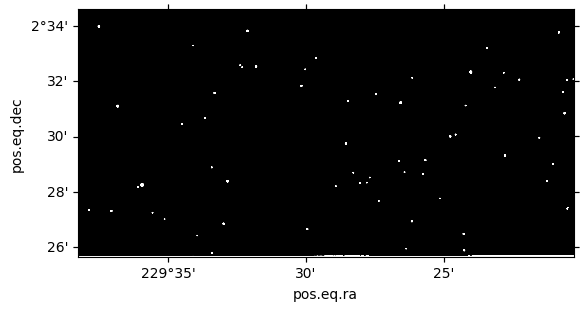

In [6]:
# get the pixel scale and coords from the header
pixscale = single_image[1].header['PIXSCALE']
ra = single_image[1].header['CRVAL1']
dec = single_image[1].header['CRVAL2']

fig = plt.figure();
ax = fig.add_subplot(111, projection=wcs)
plt.imshow(seg_map, origin='lower', cmap='grey', vmin=0, vmax=1)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm')
lat.set_major_formatter('dd:mm')

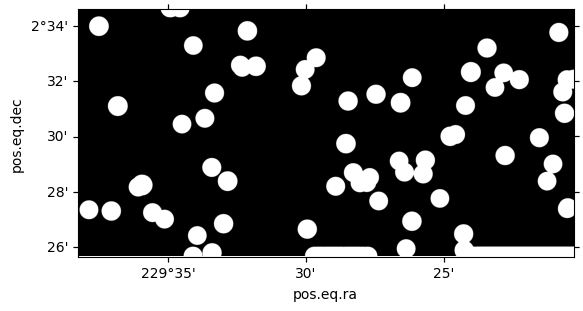

In [68]:
from scipy.ndimage import distance_transform_edt

# Calculate the distance transform of the seg_map
distance = distance_transform_edt(seg_map == 0,sampling=pixscale)

# Expand seg_map for exclusion zones
excl_map = np.copy(seg_map)
excl_map[distance <= 20] = 1

# Plot the updated seg_map
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs)
plt.imshow(excl_map, origin='lower', cmap='gray', vmin=0, vmax=1)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm')
lat.set_major_formatter('dd:mm')
plt.show()



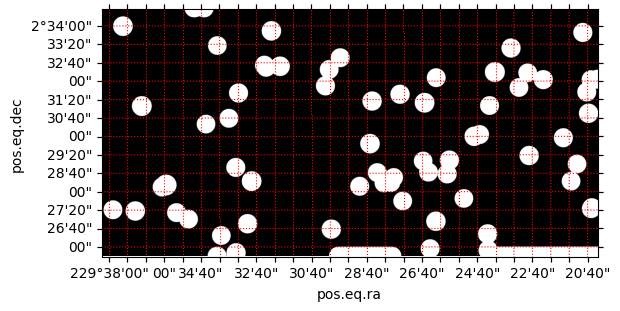

In [69]:
# Applying grid algorithm to the exclusion map
import astropy.units as u

fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs)
plt.imshow(excl_map, origin='lower', cmap='gray', vmin=0, vmax=1)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(spacing=40*u.arcsec)
lat.set_ticks(spacing=40*u.arcsec)
lon.set_ticklabel(exclude_overlapping=True)
lat.set_ticklabel(exclude_overlapping=True)
ax.coords.grid(True, color='red', ls='dotted')
plt.show()

In [96]:
dark_ra = []
dark_dec = []

for i in range(len(excl_map)):
    for j in range(len(excl_map[i])):
        if excl_map[i][j] == 0:
            dark_ra.append(j*pixscale)
            dark_dec.append(i*pixscale)

dark_coords = [dark_ra], [dark_dec]

In [100]:
dark_coords

([[0.0,
   0.27,
   0.54,
   0.81,
   1.08,
   1.35,
   1.62,
   1.8900000000000001,
   2.16,
   2.43,
   2.7,
   2.97,
   3.24,
   3.5100000000000002,
   3.7800000000000002,
   4.050000000000001,
   4.32,
   4.59,
   4.86,
   5.130000000000001,
   5.4,
   5.67,
   5.94,
   6.210000000000001,
   6.48,
   6.75,
   7.0200000000000005,
   7.290000000000001,
   7.5600000000000005,
   7.83,
   8.100000000000001,
   8.370000000000001,
   8.64,
   8.91,
   9.18,
   9.450000000000001,
   9.72,
   9.99,
   10.260000000000002,
   10.530000000000001,
   10.8,
   11.07,
   11.34,
   11.610000000000001,
   11.88,
   12.15,
   12.420000000000002,
   12.690000000000001,
   12.96,
   13.23,
   13.5,
   13.770000000000001,
   14.040000000000001,
   14.31,
   14.580000000000002,
   14.850000000000001,
   15.120000000000001,
   15.39,
   15.66,
   15.930000000000001,
   16.200000000000003,
   16.470000000000002,
   16.740000000000002,
   17.01,
   17.28,
   17.55,
   17.82,
   18.09,
   18.36,
   18.6300

In [72]:
grid_size = 40
height, width = excl_map.shape

# Calculate the number of grid squares in x and y directions
num_x_squares = int(width * pixscale / grid_size)
num_y_squares = int(height * pixscale / grid_size)

In [73]:

dark_regions = []

# Iterate through each grid square
for i in range(num_x_squares):
    for j in range(num_y_squares):
        # Calculate the coordinates of the current grid square
        x_start = int(i * grid_size / pixscale)
        x_end = int((i + 1) * grid_size / pixscale)
        y_start = int(j * grid_size / pixscale)
        y_end = int((j + 1) * grid_size / pixscale)
        
        # Check if there is any overlap with the exclusion map
        if np.all(excl_map[y_start:y_end, x_start:x_end] == 0):
            # Calculate the center of the grid square in pixel coordinates
            x_center = (x_start + x_end) / 2
            y_center = (y_start + y_end) / 2
            
            # Convert the center to RA/DEC coordinates
            ra_center, dec_center = wcs.wcs_pix2world(x_center, y_center, 1)
            
            # Append the center coordinates to the list
            dark_regions.append((float(ra_center), float(dec_center)))

dr_transpose = np.asarray(dark_regions).transpose()
dr_transpose

array([[229.63224644, 229.63223825, 229.6322362 , 229.63223415,
        229.63223209, 229.63223004, 229.63222799, 229.63222595,
        229.62113692, 229.62113054, 229.62112842, 229.62112629,
        229.62112415, 229.62111777, 229.62111564, 229.61002742,
        229.6100164 , 229.61001418, 229.61000756, 229.61000535,
        229.61000315, 229.61000094, 229.59891795, 229.59890653,
        229.59890424, 229.59890195, 229.59889966, 229.59889738,
        229.59889509, 229.59889281, 229.59889052, 229.5878085 ,
        229.58779669, 229.58779431, 229.58779194, 229.58778958,
        229.58778722, 229.58778486, 229.58778249, 229.57669175,
        229.57668931, 229.57668687, 229.57667953, 229.57667709,
        229.5655471 , 229.56554458, 229.56552188, 229.55437923,
        229.55437663, 229.55437403, 229.54329589, 229.5432825 ,
        229.54327982, 229.54327713, 229.54327445, 229.53218657,
        229.53218382, 229.53218106, 229.53217831, 229.53217555,
        229.5321728 , 229.53217003, 229.

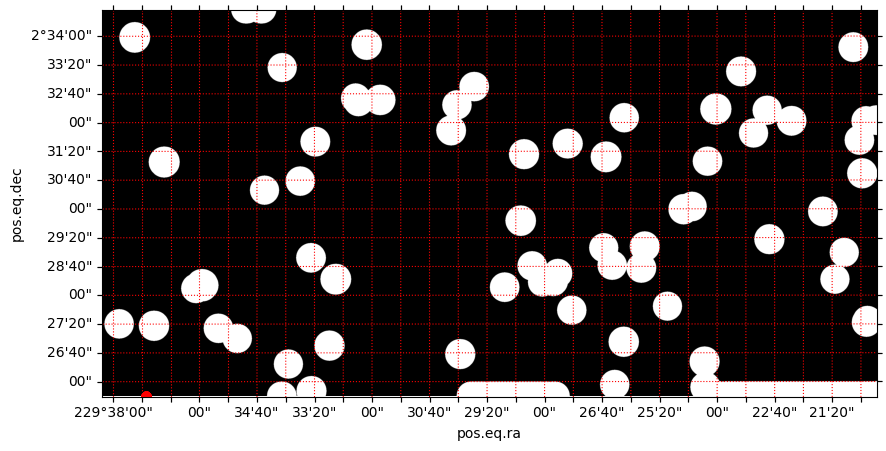

In [75]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection=wcs)

plt.plot(dr_transpose[0], dr_transpose[1],'ro', zorder=2)
plt.imshow(excl_map, origin='lower', cmap='grey', vmin=0, vmax=1, zorder=1)


lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(spacing=40*u.arcsec)
lat.set_ticks(spacing=40*u.arcsec)
lon.set_ticklabel(exclude_overlapping=True)
lat.set_ticklabel(exclude_overlapping=True)
ax.coords.grid(True, color='red', ls='dotted')

plt.show()

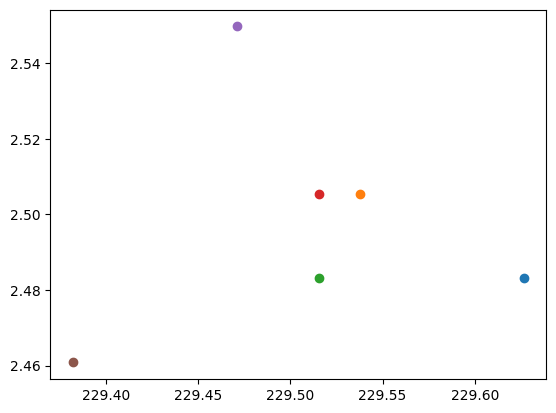

In [35]:
for i in range(len(dark_regions)):
    plt.plot(dark_regions[i][0], dark_regions[i][1],'o', zorder=2)

In [277]:
dark_regions[i][0]

229.3820543447609